In [ ]:
## We will use CorLoc
# norm is filter all the squares that don't fit criteria...

# Steps:
# 1. Load UA_detrac
# 2. Get the model output
# 3. Perform evaluation


In [1]:
## Load the data

%load_ext autoreload
%autoreload 2

%pylab inline
import os
import cv2
import time
import numpy as np
import pandas as pd

import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image


os.getcwd()
home_dir = os.path.abspath('../../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac',  'DETRAC-Images')
data_dir

home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X, length_per_mvi = load.load_images(image_dir, grayscale = False)
Y_dict = load.load_XML(anno_dir, X, length_per_mvi)

print("Total time to load small data is", time.time() - start_time, "seconds")

  0%|          | 4/10421 [00:00<04:29, 38.65it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10421


 14%|█▍        | 1465/10421 [00:11<01:04, 138.23it/s]

KeyboardInterrupt: 

 14%|█▍        | 1465/10421 [00:30<01:04, 138.23it/s]

In [3]:
def _split_train_test(X,Y_dict):
    n_samples, _, _, _= X.shape
    print(n_samples)
    train_index_end = int(len(X) * 0.8)
    print(train_index_end)

    X_train = X[:train_index_end]
    X_test = X[train_index_end:]

    Y_dict_train = {}
    Y_dict_test = {}
    for column in Y_dict:
        Y_dict_train[column] = Y_dict[column][:train_index_end]
        Y_dict_test[column] = Y_dict[column][train_index_end:]

    return X_train, X_test, Y_dict_train, Y_dict_test

X_train, X_test, Y_train_dict, Y_test_dict = _split_train_test(X, Y_dict)


10421
8336


In [20]:
X_train.shape

(8336, 540, 960, 3)

In [5]:
import xml.etree.ElementTree as ET

In [6]:
anno_files = os.listdir(anno_dir)
anno_files.sort()
print(anno_files)

['MVI_20011.xml', 'MVI_20012.xml', 'MVI_20032.xml', 'MVI_20033.xml', 'MVI_20034.xml', 'MVI_20035.xml', 'MVI_20051.xml', 'MVI_20052.xml', 'MVI_20061.xml', 'MVI_20062.xml', 'MVI_20063.xml', 'MVI_20064.xml', 'MVI_20065.xml']


In [21]:
from utils import *
boxes_dataset = get_boxes(anno_dir, width = 300, height = 300)

skipping .ipynb_checkpoints


In [45]:
train_index_end = int(len(X) * 0.8)
test_boxes = boxes_dataset[train_index_end:]
print(len(test_boxes))

2085


In [22]:
len(boxes_dataset)

10421

In [23]:

X_train_norm = np.copy(X_train)
X_test_norm = np.copy(X_test)

def _format_image_fixed(X, height, width):
    n_samples,_,_,channels = X.shape
    X_new = np.ndarray(shape=(n_samples, height, width, channels))
    for i in range(n_samples):
        X_new[i] = cv2.resize(X[i],  (width,height))
    
    X_new /= 255.0
        
    return X_new


def _format_image(X, sampling_rate=12):
    print("before:", X.shape)
    reduction_rate = sampling_rate
    # need to down shape them so that the kernels can train faster
    # image should be num_samples, height, width, channel
    downsampled_images = X[:, ::reduction_rate, ::reduction_rate, :]
    downsampled_images = downsampled_images.astype(np.float32)
    print("After change, shape of image is", downsampled_images.shape)
    downsampled_images /= 255.0
    return downsampled_images

X_train_norm = _format_image_fixed(X_train_norm, 300, 300)
X_test_norm = _format_image_fixed(X_test_norm, 300, 300)


[(210, 185, 300, 235), (67, 174, 91, 189), (49, 170, 65, 181), (37, 158, 51, 167), (38, 172, 49, 182), (63, 228, 85, 244), (138, 281, 198, 300)]


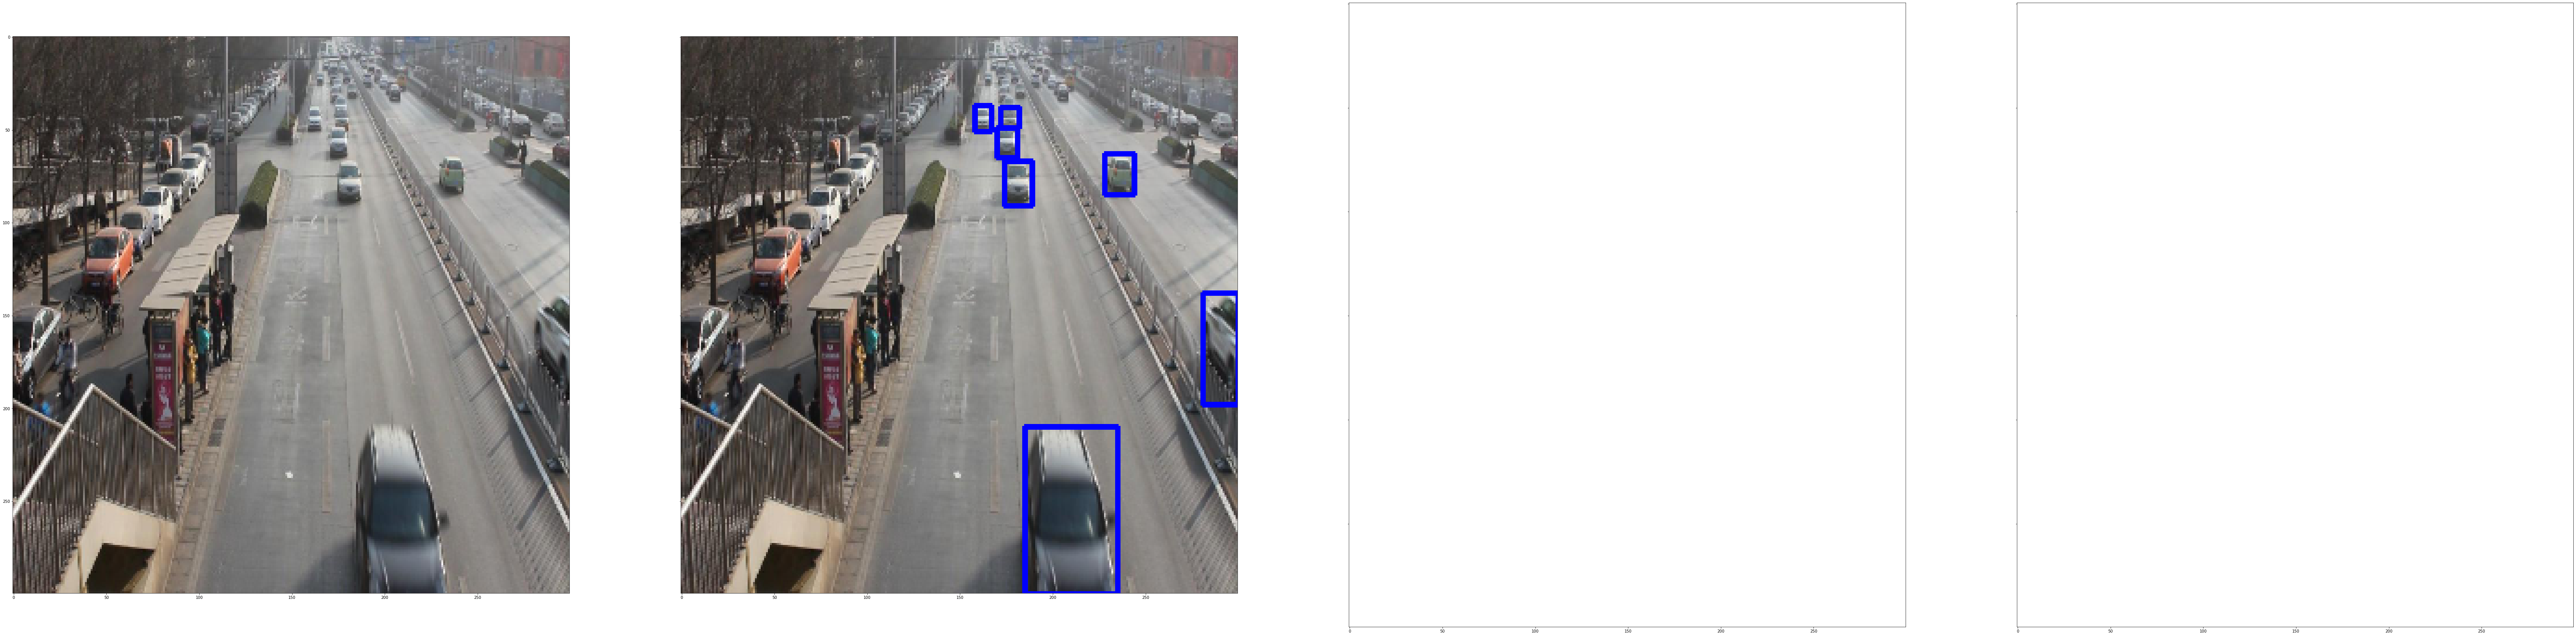

In [32]:
## as a safety check show the images with box annotations
rows = 1
cols = 4
size = 30
fig, axes = plt.subplots(rows, cols, figsize = (size*cols, size*rows), sharex = True, sharey = True)

######


example = np.copy(X_train_norm[0]) * 255.0
example = example.astype(np.uint8)
axes[0].imshow(example)

example1 = np.copy(example)
boxes0 = boxes_dataset[0]
color = (0, 0, 255)


print(boxes0)
for box in boxes0:
    cv2.rectangle(example1, (box[1], box[0]), (box[3], box[2]), color, 2)

axes[1].imshow(example1)

In [33]:
## load the results from model
test_images = np.load('test_images.npy')
post_seg = np.load('post_seg.npy')
model_output = np.load('model_output.npy')


In [34]:
## load the results from model
from utils import *

# let's work on our own post method... enlarge the white area and take away things that are not 'bright enough'
rows = 5
cols = 9
size = 30
fig, axes = plt.subplots(rows, cols, figsize = (size*cols, size*rows), sharex = True, sharey = True)


for ii in range(rows):
    ri = random.randint(0, 2000)
    tmp = test_images[ri]
    tmp_seg = model_output[ri]

    labels, results = post_individual_v2(tmp_seg)
    assert(len(labels) == len(results))
    print(labels)

    for i in range(min(cols,len(results))):
        axes[ii,i].imshow(results[i], cmap = 'gray')

    #overlap the image
    post = results[-1]
    patches = detect_patches(post)
    detected_img = draw_patch(tmp, patches)
    axes[ii,2].imshow(detected_img)
    
    overlapped = overlap1(tmp, post)
    axes[ii,3].imshow(overlapped)
    
    detected_img = draw_patches(tmp, patches)
    axes[ii,4].imshow(detected_img)
    
    ### Let's do box filtering!! TODO!!!!
    ## 1. If box is too small, then exclude it
    ## 2. If the box aspect ratio is bad ( too horizontal, then exclude)
    new_patches = filter_patches(patches)
    detected_img = draw_patches(tmp, new_patches)
    axes[ii,5].imshow(detected_img)


['median blur', 'ostu on median']
['median blur', 'ostu on median']
['median blur', 'ostu on median']
['median blur', 'ostu on median']
['median blur', 'ostu on median']


In [36]:
## let's do evaluation
## 1. Extract the boxes and save them
## 2. Use precision / recall methods implemented

n_test_samples = test_images.shape[0]
proposed_boxes = []
for i in range(n_test_samples):
    tmp = test_images[i]
    tmp_seg = model_output[i]

    labels, results = post_individual_v2(tmp_seg)
    assert(len(labels) == len(results))
    
    post = results[-1]
    patches = detect_patches(post)
    
    ### Let's do box filtering!! TODO!!!!
    ## 1. If box is too small, then exclude it
    ## 2. If the box aspect ratio is bad ( too horizontal, then exclude)
    new_patches = filter_patches(patches)
    new_patches = reorder_patches(new_patches)
    ## Check if the new_patches are according to our specification
    
    proposed_boxes.append(new_patches)


    
    

No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image
No contours in image


In [38]:
print(len(proposed_boxes))

2085


In [39]:
print(test_images.shape[0])

2085


In [43]:
print(len(boxes_dataset))

10421


In [65]:


precision, recall = corloc(test_boxes, proposed_boxes, iou = 0.5)

true positive 4789
false positive 6109
false negative 27669


In [66]:
print(precision)
print(recall)

0.43943842906955405
0.14754451907079918


In [72]:
## filter the recall results
filtered_test_boxes = filter_ground_truth(test_boxes)

precision, recall = corloc(filtered_test_boxes, proposed_boxes, iou = 0.5)



true positive 4462
false positive 6436
false negative 8281


In [73]:
print(precision)
print(recall)

0.40943292347219673
0.35015302519030056


In [ ]:
# test_boxes
# proposed_boxes

row 0
true positive 1
false positive 6
false negative 4
  precision: 0.14285714285714285  recall: 0.2
row 1
true positive 2
false positive 1
false negative 6
  precision: 0.6666666666666666  recall: 0.25
row 2
true positive 6
false positive 0
false negative 2
  precision: 1.0  recall: 0.75
row 3
true positive 3
false positive 3
false negative 7
  precision: 0.5  recall: 0.3
row 4
true positive 2
false positive 2
false negative 7
  precision: 0.5  recall: 0.2222222222222222


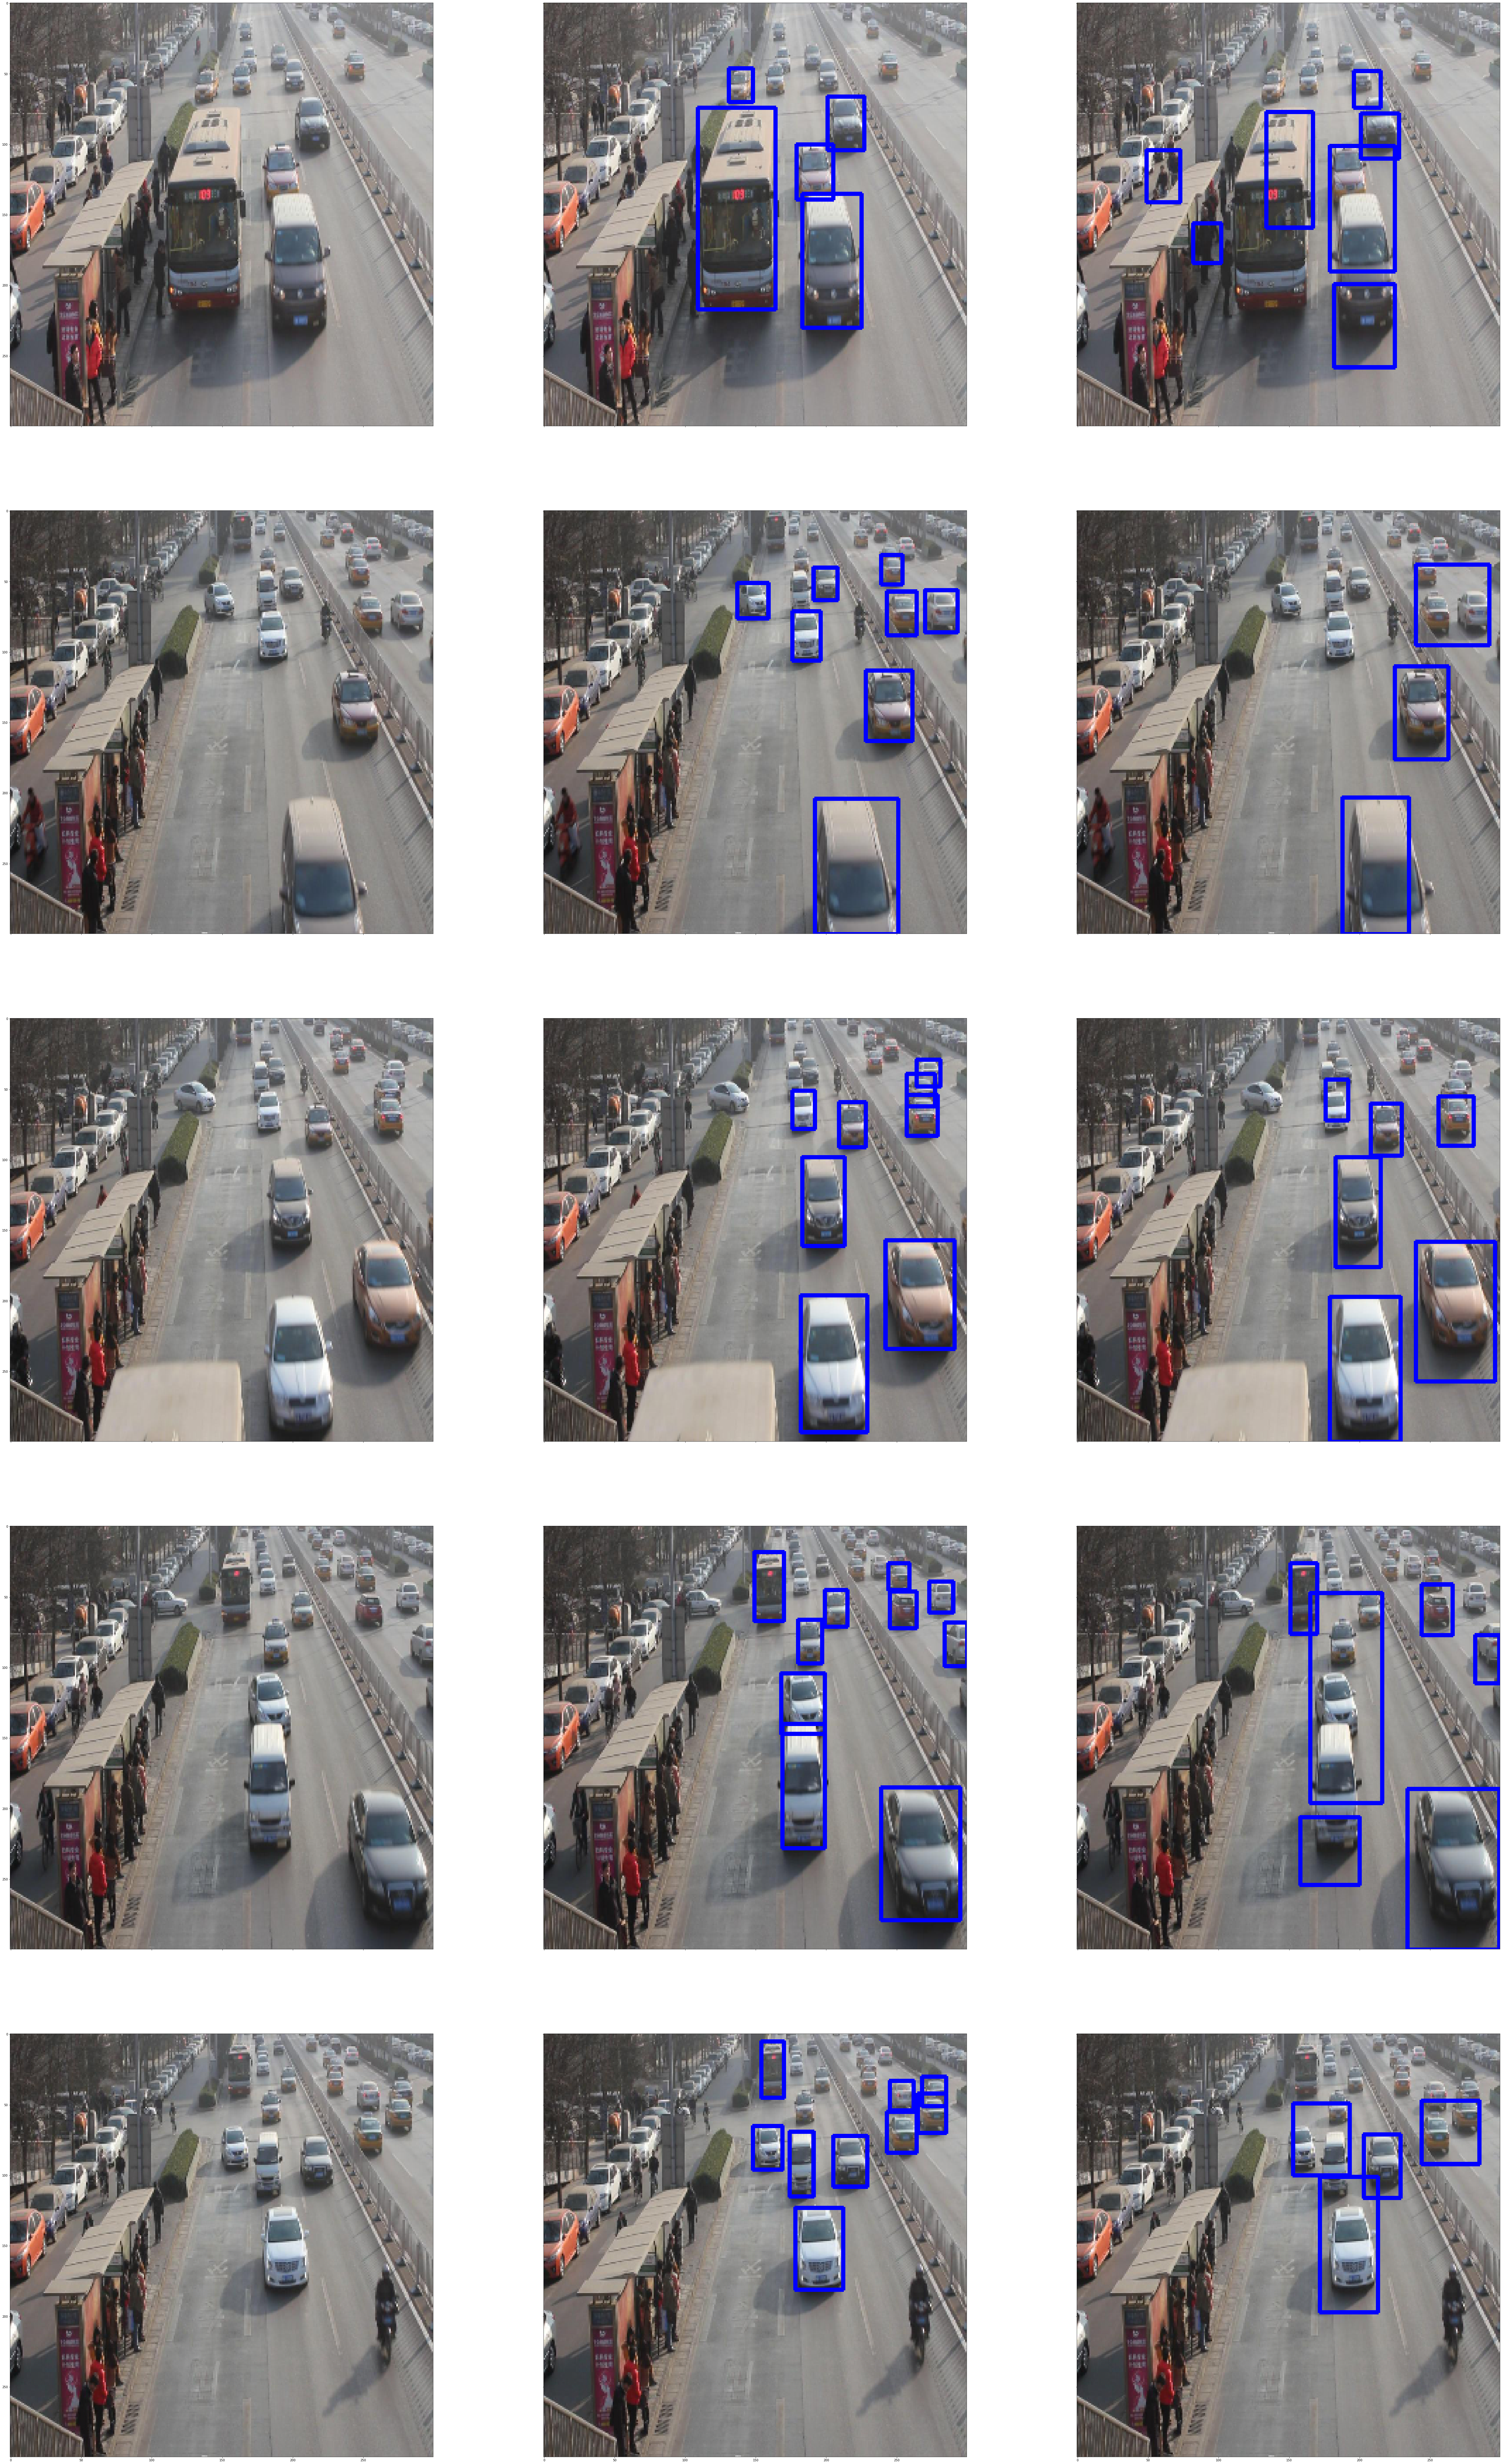

In [74]:

from utils import *

rows = 5
cols = 3
size = 30
n_samples = test_images.shape[0]
fig, axes = plt.subplots(rows, cols, figsize = (size*cols, size*rows), sharex = True, sharey = True)

for i in range(rows):
    random_index = random.randint(0, n_samples)
    axes[i, 0].imshow(test_images[random_index])
    cv_patches = ml2cv_patches(filtered_test_boxes[random_index])
    ground_image = draw_patches(test_images[random_index], cv_patches)
    axes[i, 1].imshow(ground_image)
    cv_patches2 = ml2cv_patches(proposed_boxes[random_index])
    proposed_image = draw_patches(test_images[random_index], cv_patches2)
    axes[i, 2].imshow(proposed_image)
    print("row", i)
    precision, recall = corloc([filtered_test_boxes[random_index]], [proposed_boxes[random_index]], iou = 0.5)
    print("  precision:", precision, " recall:", recall)
    
    
    
